In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch.optim import SGD,Adam
import torch.utils.data as Data 
import matplotlib.pyplot as plt
import seaborn as sns
import hiddenlayer as hl
from torchviz import make_dot
import pandas as pd

In [3]:
spam = pd.read_csv(r"D:/Users/hejie/Desktop/train_data.csv")
spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,ham,Id
0,0.0,14.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.000,0.0,0.000,0.000,0.0,1.800,5,9,True,1947
1,0.0,0.00,1.0,0.0,0.50,0.0,0.0,0.00,0.0,0.50,...,0.357,0.0,0.892,0.000,0.0,2.000,19,172,False,2159
2,0.0,0.00,0.0,0.0,0.00,0.0,0.0,1.29,0.0,0.43,...,0.124,0.0,0.310,0.062,0.0,1.477,8,65,False,4223
3,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.000,0.0,0.444,0.000,0.0,2.800,7,28,True,2624
4,0.0,0.00,0.0,0.0,1.17,0.0,0.0,0.00,0.0,1.17,...,0.000,0.0,0.000,0.000,0.0,1.551,10,45,True,2743


In [4]:
pd.value_counts(spam.ham)

True     2251
False    1429
Name: ham, dtype: int64

In [5]:
x = spam.iloc[:,0:57].values
y = spam.ham.values
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=123)
print(x)

[[0.000e+00 1.428e+01 0.000e+00 ... 1.800e+00 5.000e+00 9.000e+00]
 [0.000e+00 0.000e+00 1.000e+00 ... 2.000e+00 1.900e+01 1.720e+02]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.477e+00 8.000e+00 6.500e+01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 2.241e+00 1.500e+01 6.500e+01]
 [0.000e+00 0.000e+00 1.800e-01 ... 2.313e+00 2.400e+01 5.900e+02]
 [0.000e+00 1.250e+00 6.200e-01 ... 2.350e+00 2.900e+01 1.340e+02]]


In [6]:
scales = MinMaxScaler(feature_range=(0,1))
x_train_s = scales.fit_transform(x_train)
x_test_s = scales.transform(x_test)

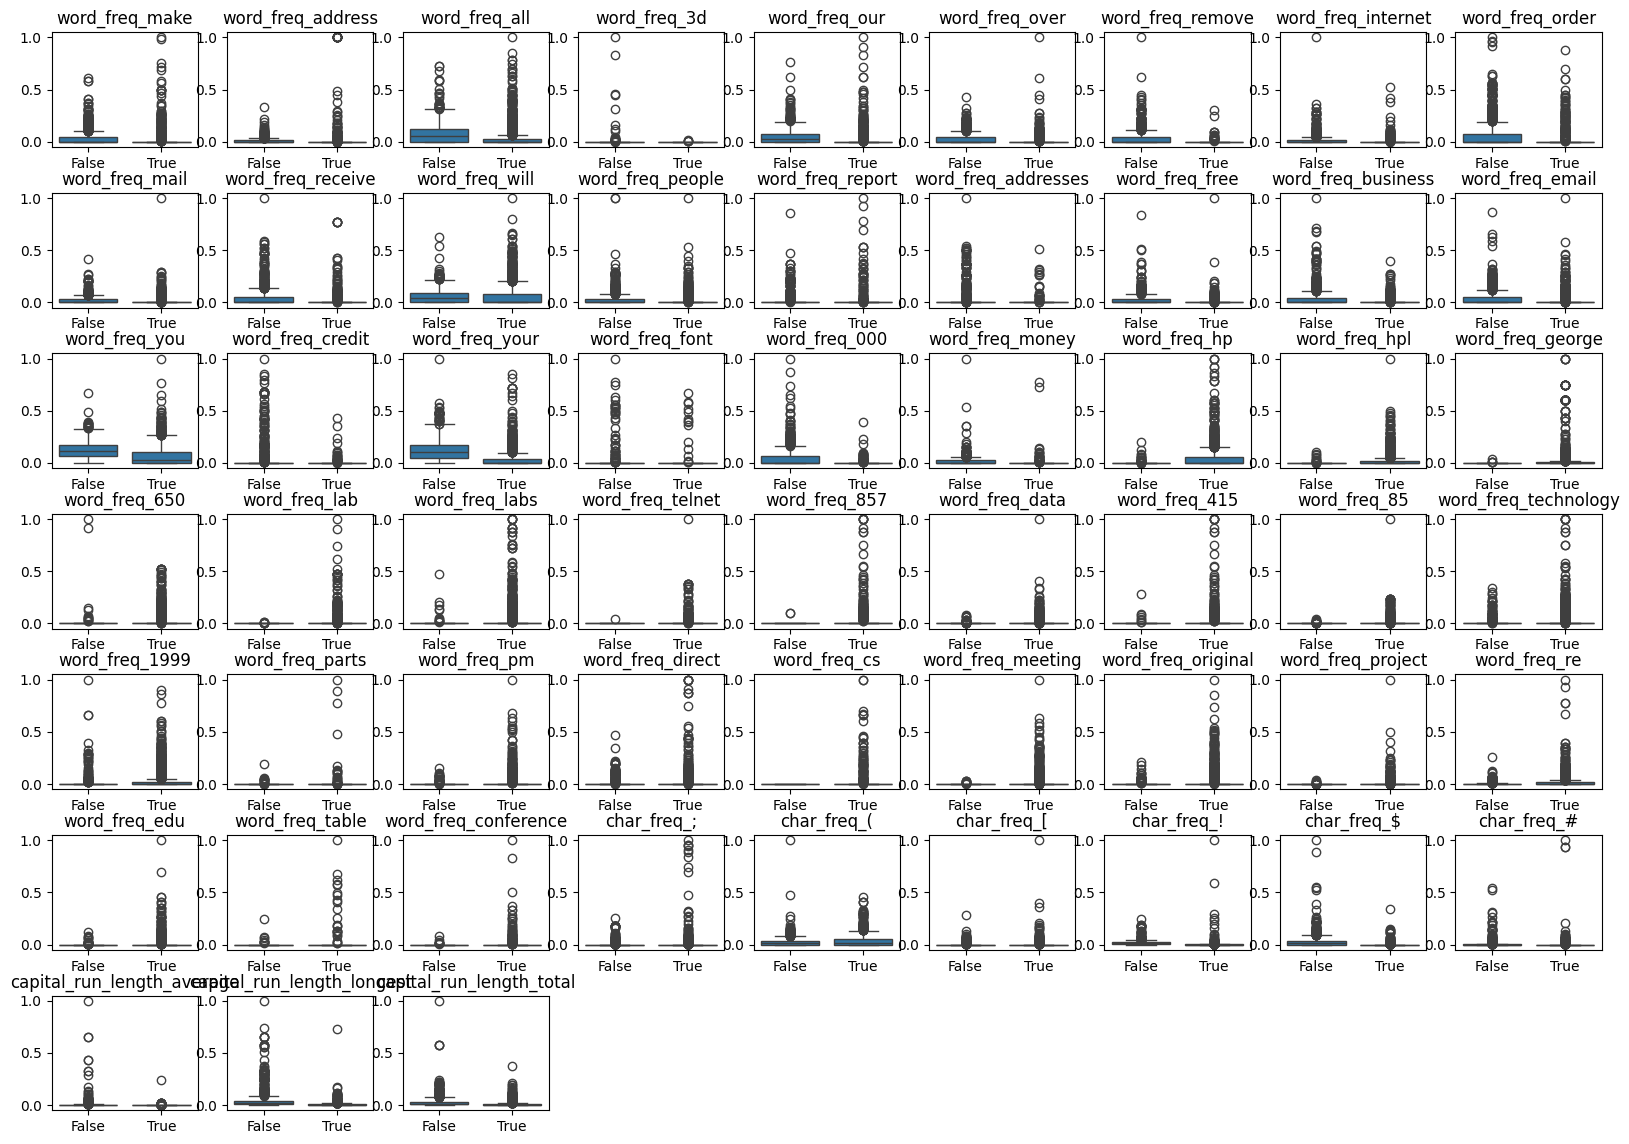

In [7]:
colname = spam.columns.values[:-2]
plt.figure(figsize=(20,14))
for ii in range(len(colname)):
    plt.subplot(7,9,ii+1)
    sns.boxplot(x = y_train,y = x_train_s[:,ii])
    plt.title(colname[ii])
plt.subplots_adjust(hspace=0.4)
plt.show()

In [8]:
class MLPclassifica(nn.Module):
    def __init__(self):
        super(MLPclassifica,self).__init__()
        self.hidden1 = nn.Sequential(
            nn.Linear(
                in_features= 57,
                out_features= 30,
                bias=True,
            ),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(30,10),
            nn.ReLU()
        )
        self.classifica = nn.Sequential(
            nn.Linear(10,2),
            nn.Sigmoid()
        )
    def forward(self, x):
        fc1 = self.hidden1(x)
        fc2 = self.hidden2(fc1)
        output = self.classifica(fc2)
        return fc1,fc2,output

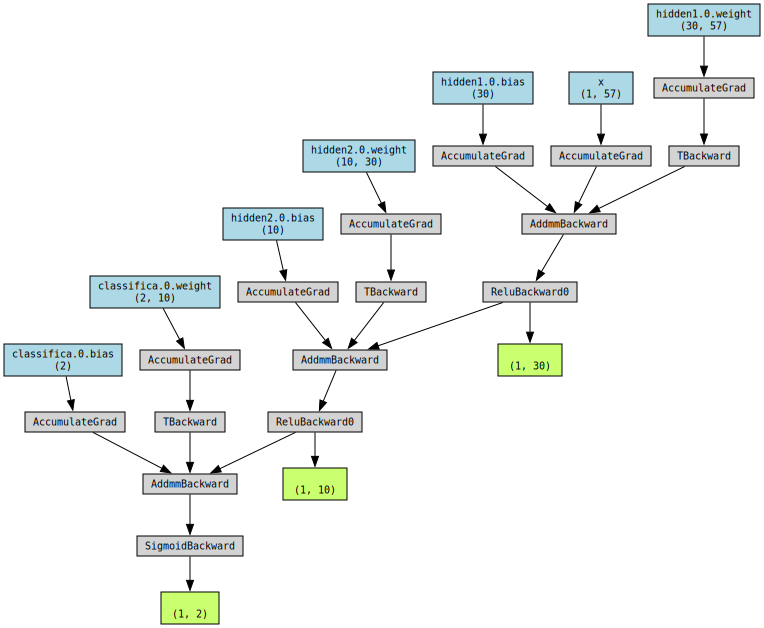

In [11]:
mlpc = MLPclassifica()
x = torch.randn(1,57).requires_grad_(True)
y = mlpc(x)
Mymlpcvis = make_dot(y,params=dict(list(mlpc.named_parameters())+ [('x',x)]))
Mymlpcvis

In [13]:
x_train_t = torch.from_numpy(x_train_s.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.int64))
x_test_t = torch.from_numpy(x_test_s.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.int64))
train_data = Data.TensorDataset(x_train_t,y_train_t)
train_loader = Data.DataLoader(
    dataset = train_data,
    batch_size=64,
    shuffle = True,
    num_workers=1,
)

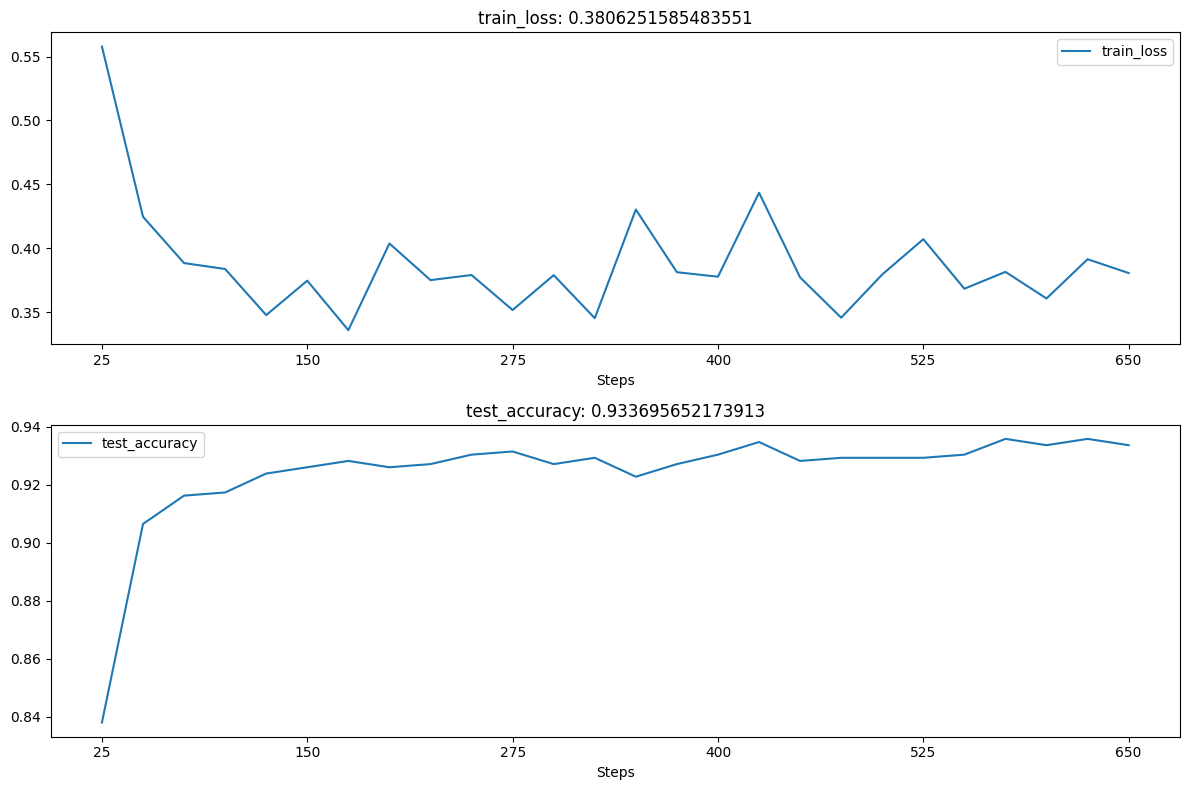

In [17]:
optimizer = torch.optim.Adam(mlpc.parameters(),lr=0.01)
loss_func = nn.CrossEntropyLoss()
history1 = hl.History()
canvas1 = hl.Canvas()
print_step = 25
for epoch in range(15):
    for step, (b_x,b_y) in enumerate(train_loader):
        _,_,output = mlpc(b_x)
        train_loss = loss_func(output,b_y)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        niter = epoch*len(train_loader)+step+1
        if niter % print_step == 0:
            _,_,output = mlpc(x_test_t)
            _,pre_lab = torch.max(output,1)
            test_accuracy = accuracy_score(y_test_t,pre_lab)
            history1.log(niter,train_loss=train_loss,
                         test_accuracy=test_accuracy)
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_accuracy"])

In [19]:
_,_,output = mlpc(x_test_t)
_,pre_lab = torch.max(output,1)
test_accuracy = accuracy_score(y_test_t,pre_lab)
print("test_accuracy:",test_accuracy)

test_accuracy: 0.9358695652173913
